In [1]:
import multidms
import pickle

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
# import pickle
# import multidms
import os
from functools import reduce

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
# import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

In [4]:
# plt.rcParams.keys()

In [5]:
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [6]:
OUTDIR = "../results/manuscript_figures/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

In [7]:
func_score_df = pd.read_csv("../data/prepped_func_scores_rep.csv").fillna("")

In [8]:
func_score_df

,func_score,aa_substitutions,condition,replicate
0,0.4616,N87T L517F T1006A,Delta,1
1,1.5096,D80L,Delta,1
2,-0.7202,A1026V D1168Y,Delta,1
3,1.1890,G75W K1154E,Delta,1
4,-1.2116,T307S S803L A893V,Delta,1
...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2
689431,-2.3933,S27F G413E,Omicron_BA2,2


In [9]:
model_set = "../results/ridge_ch_30K/"
models = pickle.load(open(f"{model_set}/models.pkl", "rb"))
models.head()

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate
0,<multidms.data.MultiDmsData object at 0x7f1c27...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9457752724757239, 0.8002926034800666, 0.740...",<multidms.model.MultiDmsModel object at 0x7f1c...,0
1,<multidms.data.MultiDmsData object at 0x7f1c2a...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9400713589182407, 0.7854160730979735, 0.717...",<multidms.model.MultiDmsModel object at 0x7f1a...,1
2,<multidms.data.MultiDmsData object at 0x7f1c27...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9451376913088765, 0.8007392249549228, 0.739...",<multidms.model.MultiDmsModel object at 0x7f1a...,0
3,<multidms.data.MultiDmsData object at 0x7f1c2a...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9410402097392394, 0.7858163889446297, 0.720...",<multidms.model.MultiDmsModel object at 0x7f1a...,1
4,<multidms.data.MultiDmsData object at 0x7f1c27...,1,0.00001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9611385623566833, 0.8140179139439288, 0.756...",<multidms.model.MultiDmsModel object at 0x7f1a...,0


## Barcodes

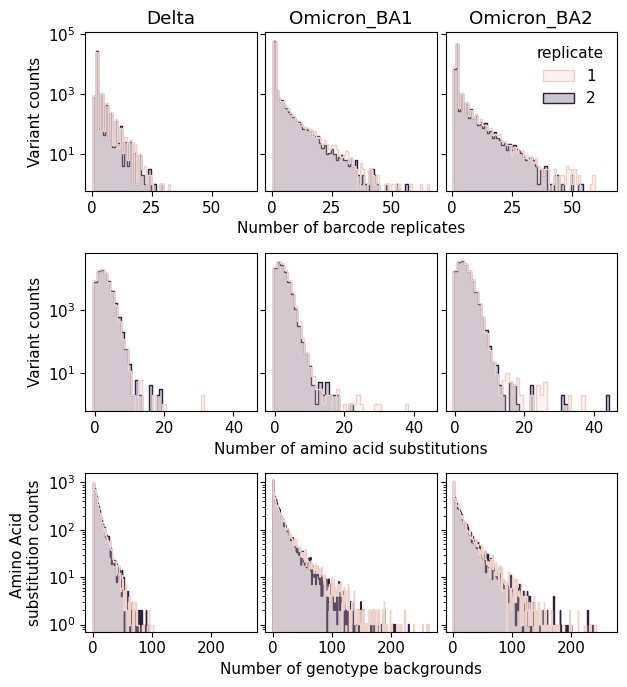

In [10]:
saveas = f"raw_data_summary_barcodes_backgrounds_hist"

fig, ax = plt.subplots(3,3, sharex="row", sharey="row", figsize=[6.4, 7])

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    vc = condition_df.value_counts(["aa_substitutions", "replicate"]).reset_index()
    wt_vc = vc.query("aa_substitutions == ''")
    non_wt_vc = vc.query("aa_substitutions != ''")
    non_wt_vc = non_wt_vc.assign(num_barcodes = non_wt_vc['count'].astype('category'))
    sns.histplot(non_wt_vc, x="num_barcodes", ax=iter_ax, hue="replicate", element="step") #, discrete=True)
    iter_ax.set_yscale('log')
    if col != 2: 
        iter_ax.get_legend().remove()
    else:
        iter_ax.get_legend()
        
    xlabel = "Number of barcode replicates" if col == 1 else ""
    ylabel = "Variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xlabel(xlabel)
    iter_ax.set_title(condition)


row = 1
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = condition_df.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in condition_df.aa_substitutions
        ]
    )
    
    df = df.assign(num_muts = df['num_muts'].astype('category'))
    
    sns.histplot(df, x="num_muts", ax=iter_ax, hue="replicate", element="step") #, discrete=True)
    iter_ax.set_yscale('log')
    iter_ax.get_legend().remove()
    xscale = "Number of amino acid substitutions" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    ylabel = "Variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    
row = 2
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        df = pd.concat([df, times_seen.assign(replicate=rep).reset_index()])

    df = df.assign(num_backgrounds = df['count'].astype('category'))
    
    sns.histplot(df, x="num_backgrounds", ax=iter_ax, hue="replicate", element="step") #, discrete=True)
    iter_ax.set_yscale('log')
    iter_ax.get_legend().remove()
    xscale = "Number of genotype backgrounds" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    ylabel = "Amino Acid \nsubstitution counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Correlation of Replicate Functional Scores

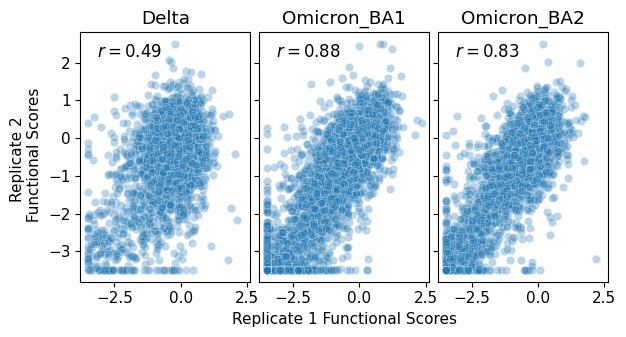

In [11]:
saveas = "replicate_functional_score_correlation_scatter"

fig, ax = plt.subplots(1,3, sharex="row", sharey="row", figsize=[6.4, 3.5])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[col]
    df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    sns.scatterplot(
        df, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        alpha=0.3
    )
    corr = pearsonr(df["rep_1_func_score"], df["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)

ax[0].set_xlabel("")
ax[0].set_ylabel("Replicate 2 \n Functional Scores")

ax[1].set_xlabel("Replicate 1 Functional Scores")
ax[2].set_xlabel("")

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Convergence Analysis

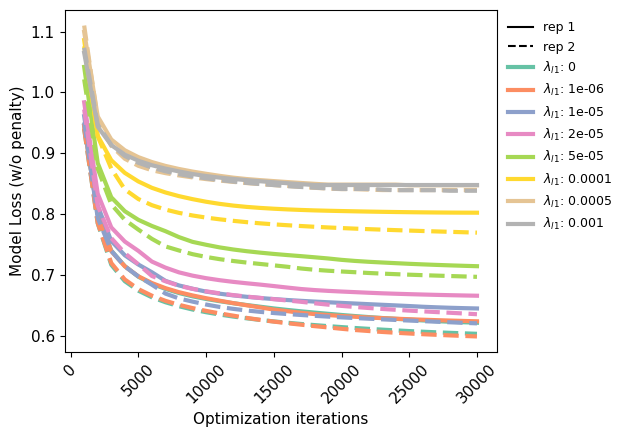

In [12]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} λ: {model_row.λ_lasso_shift}"
    )
ax.set_xticks(ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1], rotation=45, ha='center')
ax.set_ylabel("Model Loss (w/o penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda_{l1}$: "+str(lasso)
    )
    for lasso, color in zip(models.λ_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)


# fig.suptitle("Replicate Fit Convergence")
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Shrinkage Analysis

In [13]:
import jax
from collections import defaultdict

In [14]:
times_seen_threshold = 3
model_name = "model_30000"

In [15]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.λ_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )


    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if "_S_" in col and "avg" not in col
        ],
        value_name="S"
    )
    mut_df = mut_df.assign(
        λ_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "Nonsense" if "*" in mut else "Missense"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df

,mutation,S,λ_lasso,sense,condition,replicate
0,M1I,0.365254,0.0,Missense,Delta,0
1,F2L,-0.133367,0.0,Missense,Delta,0
2,F2S,0.186726,0.0,Missense,Delta,0
3,V3A,-0.092486,0.0,Missense,Delta,0
4,V3F,-0.142503,0.0,Missense,Delta,0
...,...,...,...,...,...,...
78859,S1252T,-0.000000,0.001,Missense,Omicron_BA2,1
78860,S1252V,-0.000000,0.001,Missense,Omicron_BA2,1
78861,S1252W,-0.000000,0.001,Missense,Omicron_BA2,1
78862,S1252Y,-0.000000,0.001,Missense,Omicron_BA2,1


In [16]:
def loss(model, condition):
    kwargs = {
        'λ_ridge_beta': 0.,
        'λ_ridge_shift': 0.,
        'λ_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("λ_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "Nonsense" if "*" in mut else "Missense"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference: continue
        if np.all(muts_df_inner[f"0_S_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_S_{cond}"] <= 0.05):
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
        else:
            corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])
            r = corr[0]
            interval = corr.confidence_interval()
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                tuple[(interval.low, interval.high)]
            )
        
        
        for rep, marker in zip([0,1], ["o", "D"]):
            rep_cond_shifts = muts_df_outer[[f"{rep}_S_{cond}", "sense"]].dropna()
            for sense, color in zip(["Nonsense", "Missense"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_S_{cond}"]
                sparsity = len(shifts[shifts==0]) / len(shifts)
                lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    # plot loss 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
            if cond == model.data.reference: continue
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,Delta-replicate-correlation,Delta-replicate-correlation-interval,Delta-0-Nonsense-sparsity,Delta-0-Missense-sparsity,Delta-1-Nonsense-sparsity,Delta-1-Missense-sparsity,Omicron_BA2-replicate-correlation,Omicron_BA2-replicate-correlation-interval,Omicron_BA2-0-Nonsense-sparsity,Omicron_BA2-0-Missense-sparsity,Omicron_BA2-1-Nonsense-sparsity,Omicron_BA2-1-Missense-sparsity,Delta-0-loss,Omicron_BA2-0-loss,Delta-1-loss,Omicron_BA2-1-loss
0,0.0,0.649436,"tuple[0.6320095228459721, 0.6662062290822653]",0.000000,0.000000,0.000000,0.000000,0.698584,"tuple[0.6831314875457049, 0.7134117595467968]",0.000000,0.000000,0.000000,0.000000,0.20878126988087192,0.18673930061615424,0.24558407543928598,0.17621512274569837
1,1e-06,0.668639,"tuple[0.651965496243434, 0.6846660470851382]",0.000000,0.006484,0.000000,0.006201,0.692641,"tuple[0.6769419526942047, 0.7077109880086345]",0.000000,0.008785,0.000000,0.007648,0.20968838484828134,0.1875596507683098,0.245362417728046,0.1761502312391511
2,1e-05,0.723607,"tuple[0.70921731147717, 0.7373937268152438]",0.363636,0.105208,0.329670,0.110169,0.692311,"tuple[0.6765974015927004, 0.7073935269866086]",0.415584,0.165237,0.406593,0.146962,0.21728593425845505,0.1946640510742787,0.2570902114259448,0.18425789002783124
3,2e-05,0.736083,"tuple[0.722237839286847, 0.7493376127004582]",0.727273,0.185317,0.615385,0.198636,0.728254,"tuple[0.7140661522173282, 0.7418436864184076]",0.831169,0.307676,0.857143,0.281315,0.22450889632568466,0.20096912521039878,0.26543152623553207,0.18841946812710644
4,5e-05,0.733979,"tuple[0.7200415334705302, 0.7473241506565634]",0.961039,0.389040,0.934066,0.403679,0.766749,"tuple[0.7542848652499152, 0.7786598158784751]",0.987013,0.567036,0.989011,0.541546,0.24224307111134985,0.2127154518858236,0.28434654136265564,0.19949324054447795
5,0.0001,0.677861,"tuple[0.6615570604511559, 0.6935236022398122]",1.000000,0.880151,1.000000,0.780901,0.758194,"tuple[0.7453388533627483, 0.7704851434212473]",1.000000,0.913826,1.000000,0.844771,0.2761963692839127,0.23071412313239983,0.3111371143886215,0.2155335190605666
6,0.0005,NaN,NaN,1.000000,1.000000,1.000000,0.999793,NaN,NaN,1.000000,0.999791,1.000000,0.999793,0.2955295555366075,0.24429836439257377,0.3358935518271298,0.23729005809168738
7,0.001,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,0.29580652304326244,0.2443851190766541,0.33547136586106335,0.23737351025200742


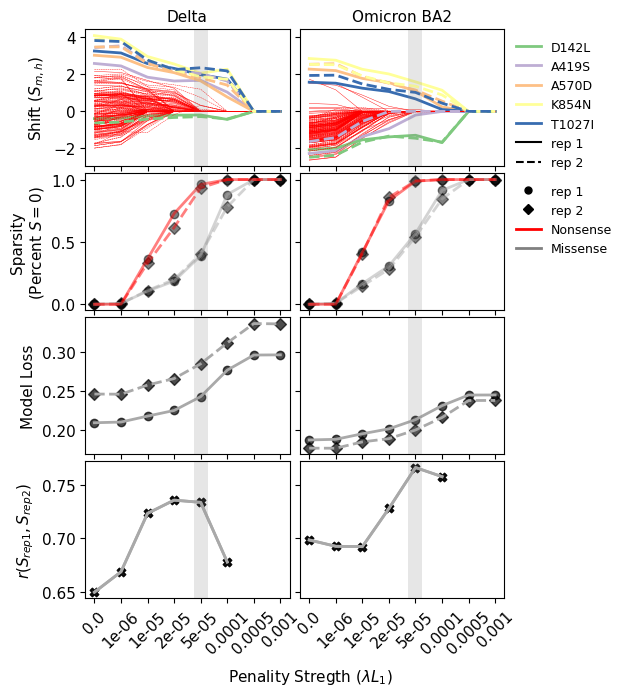

In [17]:
saveas="shrinkage_analysis_trace_plots"
fig, ax = plt.subplots(4,2, figsize=[6.4,7],sharex=True, sharey='row')

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "Missense" : "darkgrey",
    "Nonsense" : "red"
}

sense_lw = {
    "Missense" : 0.5,
    "Nonsense" : 0.3
}

sense_alpha = {
    "Missense" : 0.1,
    "Nonsense" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 10,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    
#     # plot missense, non validated
#     for mut, trace_df in df.query(
#         "sense == 'Missense' & not mutation.isin(@mutations_to_highlight)"
#     ).groupby("mutation"):
#         iter_ax.plot(
#             trace_df.λ_lasso, 
#             trace_df.S,
#             linestyle=replicate_line_style[replicate],
#             linewidth=sense_alpha['Missense'],
#             alpha=sense_alpha['Missense'],
#             color="lightgrey"
#         )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'Nonsense'").groupby("mutation"):

        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['Nonsense'],
            alpha=sense_alpha['Nonsense'],
            color=sense_colors['Nonsense']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    for sense in ["Missense", "Nonsense"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)

ax[0, 0].set_title("Delta", size=11)
ax[0, 1].set_title("Omicron BA2", size=11)

ax[0, 0].set_ylabel("Shift $(S_{m,h})$", size=11)
ax[1, 0].set_ylabel("Sparsity\n(Percent $S = 0$)", size=11)
ax[2, 0].set_ylabel("Model Loss", size=11)
ax[3, 0].set_ylabel("$r(S_{rep1},S_{rep2})$", size=11)


# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='Nonsense')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='Missense')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=45, ha='center')
ax[3,1].set_xticks(ax[3,1].get_xticks(), ax[3,1].get_xticklabels(), rotation=45, ha='center')

ax[3,0].set_xlabel(f"Penality Stregth ($\lambda L_{1}$)")
ax[3,0].xaxis.set_label_coords(1.1, -.5)

plt.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Global Epistasis Fits

In [18]:
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
replicate_data = {}
for row_idx, replicate_row in chosen_replicate_models.iterrows():    
     
    model = replicate_row[model_name]
    df = model.variants_df
    xlb, xub = [-1, 1] + np.quantile(df.predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(df.corrected_func_score, [0.05, 1.0])
    additive_model_grid = np.linspace(xlb, xub, num=1000)
    params = model.get_condition_params(model.data.reference)
    latent_preds = model._model_components["g"](params["α"], additive_model_grid)
    shape = (additive_model_grid, latent_preds)   
    
    replicate_data[replicate_row.replicate] = {
        "variants_df" : df,
        "wildtype_df" : model.wildtype_df,
        "epistasis_shape" : shape,
        "condition_colors" : model.data.condition_colors
    }

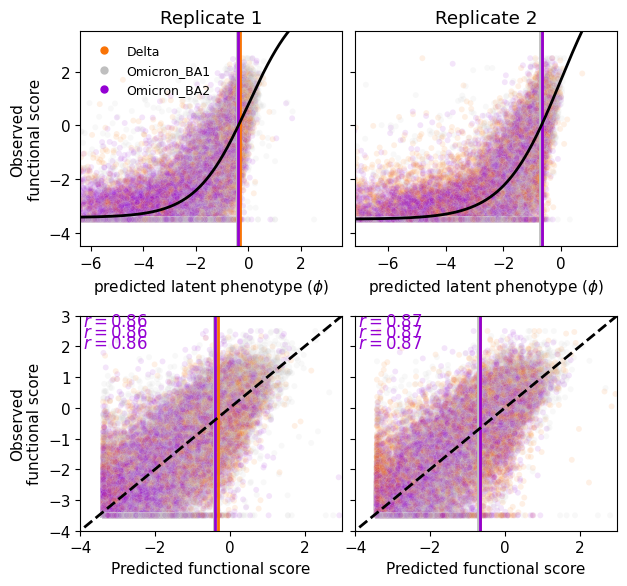

In [40]:
saveas="global_epistasis_and_prediction_correlations"
fig, ax = plt.subplots(2,2, figsize=[6.4,6], sharey='row')    

row=0
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.5),
        x="predicted_latent",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1,
        lw=3
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.plot(*data["epistasis_shape"], color="k", lw=2)
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    iter_ax.set_xlim([xlb, xub])
    iter_ax.set_ylim([ylb, yub])
    iter_ax.set_title(f"Replicate {replicate+1}")
    iter_ax.set_ylabel("Observed\nfunctional score")
    iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

row=1
for replicate, data in replicate_data.items():

    

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.5),
        x="predicted_func_score",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    
    iter_ax.plot([ylb, yub], [ylb, yub], "k--", lw=2)
    iter_ax.set_xlim([-4, 3])
    iter_ax.set_ylim([-4, 3])
    iter_ax.set_ylabel("Observed\nfunctional score")
    iter_ax.set_xlabel("Predicted functional score")

    start_y = 0.95
    for c, cdf in data["variants_df"].groupby("condition"):
        r = pearsonr(
            data["variants_df"]["predicted_func_score"],
            data["variants_df"]["corrected_func_score"]
        )[0]
        iter_ax.annotate(
            f"$r = {r:.2f}$",
            (0.01, start_y),
            xycoords="axes fraction",
            fontsize=12,
            c=model.data.condition_colors[condition],
        )
        start_y += -0.05


elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


ax[0, 0].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)
    
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()


## Percent Shifts Under X

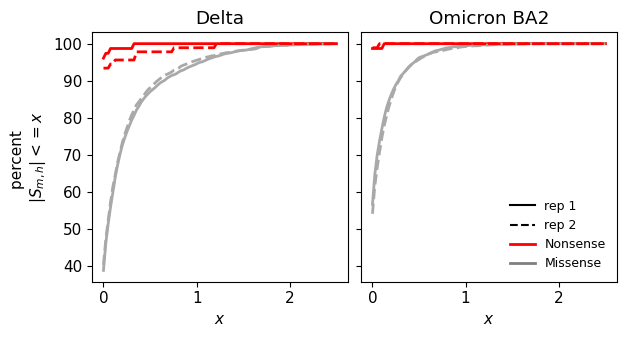

In [20]:
saveas = "percent_shifts_under_x_lineplot"
fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharey='row')
tall_mut_df_chosen = tall_mut_df.query("λ_lasso == '5e-05'")

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

sense_colors = {
    "Missense" : "darkgrey",
    "Nonsense" : "red"
}

t_points = np.linspace(0, 2.5, 100)
def perc_abs_lte(x, t):
    abs_x = np.abs(x)
    return len(abs_x[abs_x<=t]) / len(x) #)*100

for (condition, replicate, sense), df in tall_mut_df_chosen.groupby(["condition", "replicate", "sense"]):
    iter_ax = ax[condition_col[condition]]
    lt_percentages = [perc_abs_lte(df["S"], t)*100 for t in t_points]
    iter_ax.plot(
        t_points, 
        lt_percentages,
        linestyle = replicate_line_style[replicate],
        color = sense_colors[sense],
        linewidth = 2 
    )
    
ax[condition_col["Delta"]].set_title("Delta")
ax[condition_col["Omicron_BA2"]].set_title("Omicron BA2")

ax[0].set_ylabel("percent \n$|S_{m,h}| <= x$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='Nonsense')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='Missense')
ax[1].legend(
    handles=[black_line, black_dashed, red_line, grey_line], 
    bbox_to_anchor = (1, 0), 
    loc='lower right', 
    frameon=False, 
    fontsize=9
)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Correlation of BA2 and Delta Shifts

In [21]:
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)

In [22]:
mut_df_replicates["sense"] = ["Nonsense" if mut == "*" else "Missense" for mut in mut_df_replicates.muts]

In [23]:
# fig, ax = plt.subplots(1,figsize=[6.4,5.5])
# sns.jointplot(
#     data=mut_df_replicates,
#     x="avg_S_Delta",
#     y="avg_S_Omicron_BA2",
#     hue = "sense",
# #     kind="reg", 
# #     truncate=False,
# #     kind="hist",
# #     xlim=(0, 60), ylim=(0, 12),
# #     color="m", 
# #     height=7
#     height=5,# ratio=2,
#     marginal_ticks=True,
# #     joint_kws=dict(=10),
# #     marginal_kws=dict(bins=25, fill=False, stat="density")
# )
# plt.show()

Note that we're plotting the average. that's why less correlation between delta shifts makes the density of nonsense so much smaller for Delta

## Sitewise Sum of Shifts by Site

In [24]:
mut_df_replicates

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2,sense
mutation,,,,,,,,,,,,,
M1I,M,1,I,-2.975049,-3.927958,-3.451503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Missense
F2L,F,2,L,0.186080,0.210534,0.198307,-0.000000,-0.000000,0.000000,-0.201996,0.000000,-0.100998,Missense
V3A,V,3,A,-0.016013,-0.042291,-0.029152,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,Missense
V3F,V,3,F,-0.268199,-0.217794,-0.242996,-0.000000,-0.000000,0.000000,-0.000000,0.018426,0.009213,Missense
V3G,V,3,G,0.007358,0.050401,0.028880,0.000000,0.000000,0.000000,0.000000,-0.021452,-0.010726,Missense
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.119991,0.175312,0.147651,-0.070250,-0.000000,-0.035125,0.058270,0.000000,0.029135,Missense
S1252T,S,1252,T,-0.136357,-0.188409,-0.162383,-0.000000,0.000000,0.000000,-0.060079,-0.000000,-0.030040,Missense
S1252V,S,1252,V,0.157162,0.178422,0.167792,0.257386,-0.183734,0.036826,-0.036923,-0.110835,-0.073879,Missense


## Comparison to Naive approach

In [25]:
# rep correlation, distribution of shifts w/ stop codons

## Betas and Shifts (Distributions and Correlations)

## Shifted Mutations, Heat and Sitemap

In [26]:
# could add a 'min' column of 0, and 1
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = ["Nonsense" if mut == "*" else "Missense" for mut in mut_df_replicates.muts]
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)
site_map = model.data.site_map
mut_df_replicates = (
    mut_df_replicates
    .merge(
        site_map,
        left_on="sites",
        right_index=True,
        how="left"
    )
#     .drop("wts", axis=1)
    .rename(
        {
            "Omicron_BA1": "BA1_wt",
            "Delta": "Delta_wt",
            "Omicron_BA2" : "BA2_wt"
        },
        axis=1
    )
)
mut_df_replicates = mut_df_replicates.assign(
#     is_BA1_wt = [
#         True if aad == aar else False
#         for aad, aar in zip(mut_df_replicates.BA1_wt,mut_df_replicates.BA1_wt)
#     ],
    is_Delta_wt = [
        True if aad == aar else False
        for aad, aar in zip(mut_df_replicates.Delta_wt,mut_df_replicates.BA1_wt)
    ],
    is_BA2_wt = [
        True if aad == aar else False
        for aad, aar in zip(mut_df_replicates.BA2_wt,mut_df_replicates.BA1_wt)
    
    ]
)
mut_df_replicates.head()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_BA2,1_S_BA2,avg_S_BA2,sense,Delta_wt,BA1_wt,BA2_wt,is_Delta_wt,is_BA2_wt
mutation,,,,,,,,,,,,,,,,,,
M1I,M,1,I,-2.975049,-3.927958,-3.451503,0.0,0.0,0.0,0.000000,0.000000,0.000000,Missense,M,M,M,True,True
F2L,F,2,L,0.186080,0.210534,0.198307,-0.0,-0.0,0.0,-0.201996,0.000000,-0.100998,Missense,F,F,F,True,True
V3A,V,3,A,-0.016013,-0.042291,-0.029152,-0.0,-0.0,0.0,-0.000000,-0.000000,0.000000,Missense,V,V,V,True,True
V3F,V,3,F,-0.268199,-0.217794,-0.242996,-0.0,-0.0,0.0,-0.000000,0.018426,0.009213,Missense,V,V,V,True,True
V3G,V,3,G,0.007358,0.050401,0.028880,0.0,0.0,0.0,0.000000,-0.021452,-0.010726,Missense,V,V,V,True,True


In [27]:
same_fx = lambda x: x[0] if np.all(x == x[0]) else -1
cols_to_collapse = [col for col in mut_df_replicates.columns if "avg_" in col]
cols_to_collapse.extend(['sites', 'sense', 'BA1_wt', 'BA2_wt', 'Delta_wt', 'is_BA2_wt', 'is_Delta_wt'])
shifts_by_site = mut_df_replicates[cols_to_collapse].groupby("sites").agg(
    max_abs_S_BA2 = ('avg_S_BA2', lambda x: np.max(np.abs(x))),
    max_abs_S_Delta = ('avg_S_Delta', lambda x: np.max(np.abs(x))),
    
    mean_S_BA2 = ('avg_S_BA2', np.mean),
    mean_S_Delta = ('avg_S_Delta', np.mean),
    
    sum_S_BA2 = ('avg_S_BA2',  np.sum),
    sum_S_Delta = ('avg_S_Delta', np.sum),

#     is_BA1_wt=('is_BA1_wt', same_fx),
    BA2_wt=('BA2_wt', same_fx),
    Delta_wt=('Delta_wt', same_fx),
    is_BA2_wt=('is_BA2_wt', same_fx),
    is_Delta_wt=('is_Delta_wt', same_fx)
)
assert -1 not in shifts_by_site.Delta_wt
# assert -1 not in shifts_by_site.BA1_wt
assert -1 not in shifts_by_site.BA2_wt
shifts_by_site

,max_abs_S_BA2,max_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,BA2_wt,Delta_wt,is_BA2_wt,is_Delta_wt
sites,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,True,True
2,0.100998,0.000000,-0.100998,0.000000,-0.100998,0.000000,F,F,True,True
3,0.110398,0.079056,0.032543,0.013176,0.195255,0.079056,V,V,True,True
4,0.060683,0.125552,-0.024123,-0.036539,-0.072370,-0.109617,F,F,True,True
5,0.655798,0.280303,0.041203,-0.081128,0.700453,-1.379179,L,L,True,True
...,...,...,...,...,...,...,...,...,...,...
1248,0.043238,0.165269,-0.001671,0.046353,-0.010029,0.278118,C,C,True,True
1249,0.035850,0.058838,0.008856,-0.019968,0.035422,-0.079870,S,S,True,True
1250,0.062389,0.124266,-0.008907,0.033581,-0.053441,0.201488,C,C,True,True


In [28]:
shifts_by_site.index.dtype

dtype('int64')

In [29]:
site_map.reset_index().rename({"index":"site"})

,index,Delta,Omicron_BA1,Omicron_BA2
0,1,M,M,M
1,2,F,F,F
2,3,V,V,V
3,4,F,F,F
4,5,L,L,L
...,...,...,...,...
1235,1248,C,C,C
1236,1249,S,S,S
1237,1250,C,C,C
1238,1251,G,G,G


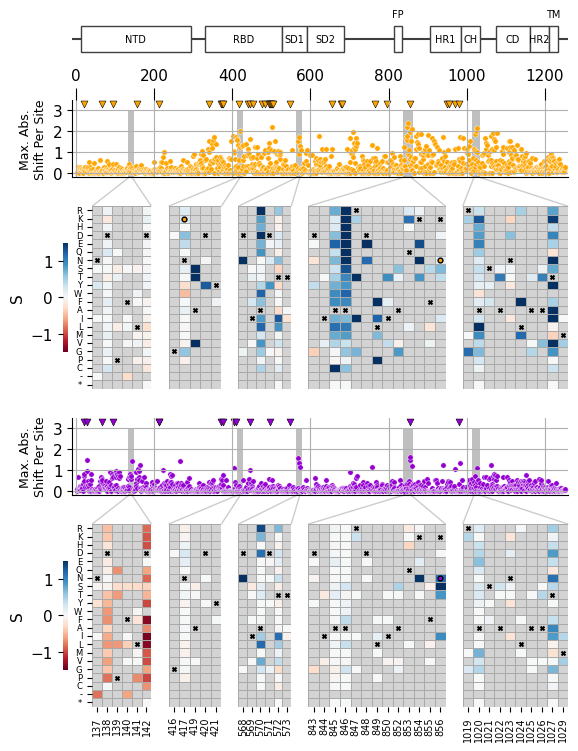

In [30]:
saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())], 
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):


#     tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
#     trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox

    
#     mybbox2 = TransformedBbox(ax1.viewLim, trans)    
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

#     ax1.add_patch(bbox_patch1)
#     ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}


# Plot per-site metric
metric_prefix = 'max_abs_S_' # 'delta_bind_S_' # 
# metric_prefix = 'sum_S_' # 'delta_bind_S_' # 
for (i, homolog) in enumerate(['BA2', 'Delta']):
    
    sns.scatterplot(
        x='sites', 
        y=f'{metric_prefix}{homolog}',
        data=shifts_by_site, 
        s=15,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    nis = shifts_by_site.query(f"not is_{homolog}_wt")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(3.3, len(nis)),
        data=nis, 
        s=25,
        ax=axs[homolog],
#         linewidths=100,
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="black"
    )

    
    
    axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=9)
    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        #ylim=[-0.2,3],
        yticks=[0,1,2,3],
        ylabel=homolog,
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
    axs[homolog].set_ylabel("Max. Abs.\nShift Per Site")
    
    
axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -0.2), site_j-site_i+11, 3.2,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_S_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.6, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : 'S'
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-1.5,
            vmax=1.5,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"Omicron_BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )#, ha="center", va="center")
                hom = homolog if homolog == "Delta" else "Omicron_BA2"
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,hom] and
                    mut !=  site_map.loc[site,"Omicron_BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog == "Delta":
            axs[f"{zoom}_{homolog}"].tick_params(axis='x', bottom=False, labelbottom=False) 
        else:
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)

fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Validation Mutations Shift V Titer fold change